## Recommender System - User-based Collaborative Filtering
Reference:
* Mining of Massive Datasets: http://www.mmds.org/
* https://github.com/nzhinusoftcm/review-on-collaborative-filtering/blob/master/2.User-basedCollaborativeFiltering.ipynb
* https://www.researchgate.net/publication/328505487_A_Survey_of_Collaborative_Filtering-Based_Recommender_Systems_From_Traditional_Methods_to_Hybrid_Methods_Based_on_Social_Networks

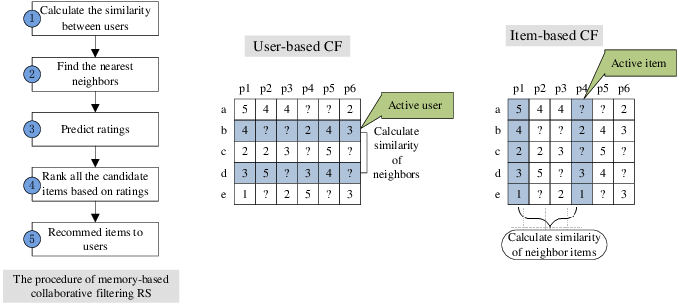

### Algorithm:
1. First identify the set $G_u$ of $k$ most similar users. $G_u$ is the group users similar to the active user $u$. The similarity between two users $u$ and $v$ can be measured by the cosine similarity measure as follows :

\begin{equation}
 w_{u,v}=\frac{\vec{r}_u \cdot \vec{r}_v}{\|\vec{r}_u\|_2 \ast \|\vec{r}_v\|_2} = \frac{\sum_{i\in I}r_{u,i}r_{v,i}}{\sqrt{\sum_{i\in I} (r_{u,i})^2}\sqrt{\sum_{i\in I} (r_{v,i})^2}}
\end{equation}

* $w_{u,v}$ is the degree of similarity between users $u$ and $v$. This term is computed for all $v\in U$, where $U$ is the set of all users. There remains the question of how many neighbors to select. $k\in [20,50]$ is a reasonable starting point in many domains.

2. Find the set $C$ of candidate items, purchased by the group and not purchased by the active user $u$. Candidate items have to be the most frequent items purchased by the group.

3. Aggregate ratings of users in $G_u$ to make predictions for user $u$ on items he has not already purchased. Several aggregation approaches are often used such as average, weighted sum, adjusted weighted sum. By using weighted sum, the predicted rating of user $u$ on item $i$ denoted by $\hat{r}_{u,i}$ is computed as follow :

\begin{equation}
 \hat{r}_{u,i}=\bar{r}_u + \frac{\sum_{v\in G_u}(r_{v,i}-\bar{r}_v)\cdot w_{u,v}}{\sum_{v\in G_u}|w_{u,v}|}.
\end{equation}

* Ratings of similar users are weighted by the corresponding similarity with the active user. Summation are made over all the users who have rated item $i$. Subtracting the user’s mean rating $\bar{r}_v$ compensates for differences in users’ use of the rating scale as some users will tend to give higher ratings than others. This prediction is made for all items $i \in C$ not purchased by user $u$.

4. The Top-$N$ recommendations are obtained by choosing the $N$ items which provide most satisfaction to the user according to prediction.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split as sklearn_train_test_split
from sklearn.preprocessing import LabelEncoder

### Load MovieLen ratings

In [8]:
import zipfile
import urllib.request
import sys
import os

DOWNLOAD_DESTINATION_DIR = "dataset"


def unzip(name):
    path = os.path.join(DOWNLOAD_DESTINATION_DIR, name)
    print(f"Unzipping the {name} zip file ...")
        
    with zipfile.ZipFile(path, 'r') as data:
        data.extractall(DOWNLOAD_DESTINATION_DIR)


def _progress(count, block_size, total_size):
    sys.stdout.write('\rDownload data %.1f%%' % (float(count * block_size)/float(total_size) * 100.0))
    sys.stdout.flush()


def download(url, name):
    path = os.path.join(DOWNLOAD_DESTINATION_DIR, name)
    if not os.path.exists(path):        
        os.makedirs(DOWNLOAD_DESTINATION_DIR, exist_ok=True)
        fpath, _ = urllib.request.urlretrieve(url, filename=path, reporthook=_progress)
        
        print()
        statinfo = os.stat(fpath)
        print('Successfully downloaded', name, statinfo.st_size, 'bytes.')
        unzip(name)


class ml100k:

    @staticmethod
    def load():        
        url = "http://files.grouplens.org/datasets/movielens/ml-100k.zip"
        name = 'ml-100k'
        
        download(url, f"{name}.zip")
        
        ratings_path = os.path.join(DOWNLOAD_DESTINATION_DIR, name, 'u.data')
        ratings = pd.read_csv(
            ratings_path,
            sep='\t',
            names=["userid", "itemid", "rating", "timestamp"],
        )
        ratings = ratings.sort_values(by=['userid', 'itemid']).reset_index(drop=True)
        ratings = ratings.drop(columns=['timestamp'])

        movies_columns = [
            'itemid', 'title', 'release date', 'video release date', 
            'IMDb URL ', 'unknown', 'Action', 'Adventure', 'Animation',
            "Children's", 'Comedy' , 'Crime' , 'Documentary' , 'Drama' , 'Fantasy' ,
            'Film-Noir', 'Horror', 'Musical' , 'Mystery' , 'Romance' , 'Sci-Fi' ,
            'Thriller' , 'War' , 'Western' ,
        ]

        movies_path = os.path.join(DOWNLOAD_DESTINATION_DIR, name, 'u.item')
        movies = pd.read_csv(
            movies_path,
            sep='|',
            names=movies_columns,
            encoding='latin-1',
        )
        # drop non necessary columns. From the third to the last column
        todrop = list(range(2, len(movies.columns)))
        movies = movies.drop(movies.columns[todrop], axis=1)
        
        return ratings, movies

In [9]:
#ratings, movies = ml100k.load()

Download data 100.2%
Successfully downloaded ml-100k.zip 4924029 bytes.
Unzipping the ml-100k.zip zip file ...


### Once downloaded

In [108]:
ratings = pd.read_csv('./dataset/ml-100k/u.data', sep='\t', names=['userid', 'itemid', 'rating', 'timestamp'])

In [109]:
ratings = ratings.sort_values(by=['userid', 'itemid']).reset_index(drop=True)
ratings = ratings.drop(columns=['timestamp'])

In [110]:
movies_columns = ['itemid', 'title', 'release date', 'video release date', 'IMDb URL ', 'unknown', 'Action', 
                  'Adventure', 'Animation', "Children's", 'Comedy' , 'Crime' , 'Documentary' , 'Drama' , 'Fantasy' ,
                  'Film-Noir', 'Horror', 'Musical' , 'Mystery' , 'Romance' , 'Sci-Fi' , 'Thriller' , 'War' , 'Western']

In [111]:
movies = pd.read_csv('./dataset/ml-100k/u.item', sep='|', names=movies_columns, encoding='latin-1')

In [112]:
movies.head(2)

,itemid,title,release date,video release date,IMDb URL,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0


In [113]:
# drop unnecessary columns
todrop = list(range(2, len(movies.columns)))
movies = movies.drop(movies.columns[todrop], axis=1)

In [114]:
movies

,itemid,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)
...,...,...
1677,1678,Mat' i syn (1997)
1678,1679,B. Monkey (1998)
1679,1680,Sliding Doors (1998)
1680,1681,You So Crazy (1994)


In [115]:
ratings

,userid,itemid,rating
0,1,1,5
1,1,2,3
2,1,3,4
3,1,4,3
4,1,5,3
...,...,...,...
99995,943,1067,2
99996,943,1074,4
99997,943,1188,3
99998,943,1228,3


### Create the encoder

In [116]:
def ids_encoder(ratings, movies):
    users = sorted(ratings['userid'].unique())
    items = sorted(ratings['itemid'].unique())

    # create users and items encoders
    uencoder = LabelEncoder()
    iencoder = LabelEncoder()

    # fit users and items ids to the corresponding encoder
    uencoder.fit(users)
    iencoder.fit(items)

    # encode userids and itemids
    ratings.userid = uencoder.transform(ratings.userid.tolist())
    ratings.itemid = iencoder.transform(ratings.itemid.tolist())
    
    # movies and ratings have the same unique itemid
    movies.itemid = iencoder.transform(movies.itemid.tolist())

    return ratings, movies

In [117]:
ratings, movies = ids_encoder(ratings, movies)

In [119]:
movies

,itemid,title
0,0,Toy Story (1995)
1,1,GoldenEye (1995)
2,2,Four Rooms (1995)
3,3,Get Shorty (1995)
4,4,Copycat (1995)
...,...,...
1677,1677,Mat' i syn (1997)
1678,1678,B. Monkey (1998)
1679,1679,Sliding Doors (1998)
1680,1680,You So Crazy (1994)


In [120]:
ratings

,userid,itemid,rating
0,0,0,5
1,0,1,3
2,0,2,4
3,0,3,3
4,0,4,3
...,...,...,...
99995,942,1066,2
99996,942,1073,4
99997,942,1187,3
99998,942,1227,3


### Transform userid-itemid rating matrix to CSR format

In [18]:
# rating matrix => we need the csr format of this matrix
pd.crosstab(ratings.userid, ratings.itemid, ratings.rating, aggfunc=sum).fillna(0)

itemid,0,1,2,3,4,5,6,7,8,9,...,1672,1673,1674,1675,1676,1677,1678,1679,1680,1681
userid,,,,,,,,,,,,,,,,,,,,,
0,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
938,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
939,0.0,0.0,0.0,2.0,0.0,0.0,4.0,5.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
940,5.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
def ratings_matrix(ratings):
    matrix = pd.crosstab(ratings.userid, ratings.itemid, ratings.rating, aggfunc=sum).fillna(0)
    return csr_matrix(matrix)

In [15]:
R = ratings_matrix(ratings)

In [16]:
print(R)

  (0, 0)	5.0
  (0, 1)	3.0
  (0, 2)	4.0
  (0, 3)	3.0
  (0, 4)	3.0
  (0, 5)	5.0
  (0, 6)	4.0
  (0, 7)	1.0
  (0, 8)	5.0
  (0, 9)	3.0
  (0, 10)	2.0
  (0, 11)	5.0
  (0, 12)	5.0
  (0, 13)	5.0
  (0, 14)	5.0
  (0, 15)	5.0
  (0, 16)	3.0
  (0, 17)	4.0
  (0, 18)	5.0
  (0, 19)	4.0
  (0, 20)	1.0
  (0, 21)	4.0
  (0, 22)	4.0
  (0, 23)	3.0
  (0, 24)	4.0
  :	:
  (942, 738)	4.0
  (942, 755)	2.0
  (942, 762)	4.0
  (942, 764)	3.0
  (942, 784)	2.0
  (942, 793)	3.0
  (942, 795)	3.0
  (942, 807)	4.0
  (942, 815)	4.0
  (942, 823)	4.0
  (942, 824)	3.0
  (942, 830)	2.0
  (942, 839)	4.0
  (942, 927)	5.0
  (942, 940)	1.0
  (942, 942)	5.0
  (942, 1010)	2.0
  (942, 1027)	2.0
  (942, 1043)	3.0
  (942, 1046)	2.0
  (942, 1066)	2.0
  (942, 1073)	4.0
  (942, 1187)	3.0
  (942, 1227)	3.0
  (942, 1329)	3.0


### Step 1. Identify $G_{u}$: the set of $k$ users similar to user of interest $u$
To find the $k$ most similar users to $u$, we use the cosine similarity and compute similarities $w_{u, v}$ for all $v \in u$. Libraries such as scikit-learn are very useful for such tasks.

### sklearn.neighbors.NearestNeighbors
Method signature: NearestNeighbors.kneighbors(self, X=None, n_neighbors=None, return_distance=True)

Returns:
1. distances: array, shape (n_samples, n_neighbors)
   * Array representing the lengths to points
2. indices: array, shape (n_samples, n_neighbors)
   * Indices of the nearest points in the training data

Explanation:

* The kneighbors method in unsupervised nearest neighbors takes a query point or set of query points (X) and finds the specified number of nearest neighbors (n_neighbors) in the training data.
* It returns the distances and indices of these neighbors.
* The distances array contains the distances from each query point to its k-nearest neighbors.
* The indices array contains the indices of the k-nearest neighbors in the training data.

**Example usage**:

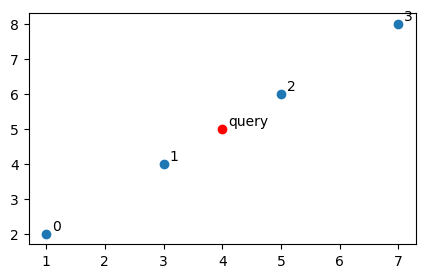

In [100]:
X = np.array([[1, 2], [3, 4], [5, 6], [7, 8]])

# plot data, annotate each point with its index
names = ['0', '1', '2', '3']
plt.figure(figsize=(5, 3))
plt.scatter(X[:, 0], X[:, 1])
for i, txt in enumerate(names):
    plt.annotate(txt, (X[i, 0]+0.1, X[i, 1]+0.1))
    
# query point
query_point = np.array([[4, 5]])
plt.scatter(query_point[0, 0], query_point[0, 1], c='r')
plt.annotate('query', (4.1, 5.1));

In [101]:
nn = NearestNeighbors(n_neighbors=2).fit(X)
distances, indices = nn.kneighbors(query_point)

In [102]:
distances

array([[1.41421356, 1.41421356]])

In [103]:
indices

array([[1, 2]], dtype=int64)

In [108]:
# query for all points in X, find its 2 nearest neighbors
nn = NearestNeighbors(n_neighbors=3).fit(X)
distances, indices = nn.kneighbors(X)

In [109]:
# we will discard the 1st column of distances, since it's the distance with itself
distances

array([[0.        , 2.82842712, 5.65685425],
       [0.        , 2.82842712, 2.82842712],
       [0.        , 2.82842712, 2.82842712],
       [0.        , 2.82842712, 5.65685425]])

In [110]:
# we will discard the 1st column of indices, since it's the index of itself
# ex: first row of indices: [0, 1, 2] => the 2 neearest neighbors to X[0] is X[1] and X[2]
indices

array([[0, 1, 2],
       [1, 0, 2],
       [2, 1, 3],
       [3, 2, 1]], dtype=int64)

In [17]:
# Get 20 nearest neighbors, n_neighbors=21 since the first column is of itself
# (see sklearn.neighbors.NearestNeighbors example usage above)
model = NearestNeighbors(metric='cosine', n_neighbors=21, algorithm='brute')
model.fit(R)

NearestNeighbors(algorithm='brute', metric='cosine', n_neighbors=21)

In [18]:
# distances, indices
similarities, neighbors = model.kneighbors(R)

# drop the first column
similarities = similarities[:, 1:]
neighbors = neighbors[:, 1:]

In [117]:
# distances/cosine similarities
pd.DataFrame(similarities)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.430934,0.452452,0.457923,0.459466,0.461335,0.461524,0.472969,0.474050,0.474282,0.475477,0.478263,0.479150,0.483022,0.485563,0.489201,0.489420,0.489657,0.491702,0.495570,0.495748
1,0.419364,0.487527,0.495582,0.523120,0.532880,0.542533,0.543345,0.544639,0.548402,0.550000,0.554290,0.554406,0.558876,0.560782,0.567165,0.571837,0.575954,0.578429,0.580501,0.580556
2,0.510968,0.514075,0.517079,0.531166,0.532558,0.537232,0.544949,0.546027,0.554504,0.556130,0.562615,0.565621,0.579365,0.581661,0.583509,0.586135,0.588286,0.590162,0.590647,0.592762
3,0.605509,0.624670,0.624810,0.640141,0.645745,0.654752,0.655849,0.658378,0.659082,0.659485,0.660789,0.664721,0.666059,0.669731,0.672940,0.678226,0.683095,0.687234,0.689153,0.690687
4,0.521115,0.524083,0.530869,0.535553,0.542505,0.544215,0.544943,0.546135,0.548625,0.555299,0.555598,0.556091,0.556498,0.556773,0.557397,0.557947,0.561796,0.563861,0.564751,0.564902
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
938,0.505028,0.567334,0.568846,0.570845,0.579186,0.582457,0.590765,0.594061,0.601830,0.606938,0.607888,0.608654,0.614578,0.622323,0.626702,0.635505,0.637785,0.638673,0.638859,0.640243
939,0.570389,0.579694,0.583483,0.588710,0.590090,0.591492,0.593966,0.596397,0.599143,0.603168,0.603455,0.603646,0.604182,0.608442,0.610281,0.610644,0.610909,0.612570,0.615278,0.616640
940,0.498310,0.535760,0.577657,0.584374,0.596099,0.596183,0.596201,0.598315,0.605146,0.612588,0.613397,0.615122,0.617862,0.618245,0.627700,0.629785,0.639608,0.641360,0.641823,0.642572
941,0.585514,0.594952,0.608005,0.613383,0.619245,0.622020,0.631621,0.634214,0.642152,0.645980,0.648625,0.650313,0.650552,0.651139,0.652986,0.653030,0.655933,0.657905,0.659096,0.659795


In [118]:
# neighbors indices
pd.DataFrame(neighbors)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,915,863,267,91,434,456,737,428,302,275,888,822,386,513,292,681,885,726,300,416
1,700,930,459,130,103,734,412,14,485,833,767,25,623,568,305,62,936,677,742,716
2,862,488,615,586,783,316,751,723,334,771,528,919,283,782,672,815,610,172,145,682
3,749,450,569,508,172,413,2,354,800,862,32,407,528,723,219,281,301,782,112,595
4,306,647,406,496,659,267,21,621,55,278,803,737,69,794,275,726,544,434,43,494
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
938,717,937,934,237,890,356,180,758,14,140,707,158,702,100,65,767,768,824,395,633
939,912,473,454,296,333,143,453,378,42,343,665,270,498,292,406,757,84,377,536,304
940,688,816,65,729,358,741,581,702,489,466,758,677,264,648,525,769,864,778,31,713
941,453,90,262,312,473,779,270,487,478,715,397,693,649,310,814,233,660,733,449,795


### Step 2. Find candidate items
Candidate items are the most frequent items purchased by an active user's neighbors in $G_{u}$. These set of candidate items have not been purchased/rated by active user $u$.

**numpy.setdiff1d(ar1, ar2, assume_unique=False)**

Find the set difference of two arrays.

Return the unique values in ar1 that are not in ar2.

In [19]:
def candidate_items(userid, neighbors, n):
    """
    Find candidate items for an active user
    
    :param userid : active user
    :param neighbors : users (indices) similar to the active user
    :param n : number of candidates, that is frequent items in Gu, not purchased by active user
    :return candidates : top n of candidate items
    """
    user_neighbors = neighbors[userid]
    # neighbors ratings
    nb_ratings = ratings.loc[ratings.userid.isin(user_neighbors)]
    items_freq = nb_ratings.groupby('itemid')['rating'].count().reset_index(name='count')
    
    # sort items in decreasing order of frequency
    items_freq = items_freq.sort_values(['count'],ascending=False)
    
    Gu_items = items_freq.itemid
    user_items = ratings.loc[ratings.userid == userid].itemid.tolist()
    
    candidates = np.setdiff1d(Gu_items, user_items, assume_unique=True)[:n]
    return candidates

### Step 3. Rating Prediction
Now it's time to predict what score the active user $u$ would have given to each of the top-30 candidate items.

To predict the score of $u$ on a candidate item $i$ ,we need :
1. Similarities between $u$ and all his neighbors $v \in G_u$ who rated item $i$
2. Normalized ratings of all $v \in G_u$ on item $i$. The normalized rating of user $v$ on item $i$ is defined by $r_{v,i}-\bar{r}_v$.

Next, let's compute the mean rating of each user and the normalized ratings for each item. The DataFrame **mean** contains mean rating for each user. With the mean rating of each user, we can add an extra column **norm_rating** ($r_{v,i}-\bar{r}_v$) which can be accessed to make predictions.

In [49]:
# mean rating for each user
users_mean = ratings.groupby('userid', as_index=False)['rating'].mean()

# add column rating_mean to ratings
ratings_with_mean = pd.merge(ratings, users_mean, suffixes=('', '_mean'), on='userid')

# add column norm_rating: mean-centered rating
ratings_with_mean['norm_rating'] = ratings_with_mean['rating'] - ratings_with_mean['rating_mean']

In [88]:
def predict(userid, itemid):
    user_similarities = similarities[userid]
    user_neighbors = neighbors[userid]
    
    # get the mean rating for user: 'userid'
    user_mean = users_mean.iloc[userid][1]
    
    # find user who rated item 'itemid'
    i_ratings = ratings_with_mean[ratings_with_mean.itemid == itemid]
    
    # find similar users to 'userid' in i_ratings
    user_neighbors = neighbors[0]
    nb_i_ratings = i_ratings[i_ratings.userid.isin(user_neighbors)]

    # get norm_rating column in nb_i_ratings
    normalized_ratings = nb_i_ratings['norm_rating']

    # indices in user_neighbors
    indices = [np.where(user_neighbors == uid)[0][0] for uid in nb_i_ratings.iloc[:, 0]]

    # get the corresponding distances
    user_similarities = similarities[0]
    sims = user_similarities[indices]
    
    numerator = np.dot(normalized_ratings.values, sims)
    denominator = np.sum(np.abs(sims))
    
    if (numerator == 0) or (denominator == 0):
        return user_mean
    
    r_hat = user_mean + (numerator / denominator)
    
    return r_hat

In [94]:
def user_based_predict(userid, n_items):
    r_hats = {}
    # Find candidate items for active user
    candidates = candidate_items(userid, neighbors, n_items)
    
    # iterate over candidates (items) to make predictions
    for itemid in candidates:
        r_hat = predict(userid, itemid)
        r_hats[itemid] = r_hat
    return r_hats

### Get a list of movies to recommend for a user

In [102]:
r_pred = user_based_predict(userid=3, n_items=30)

In [131]:
# Rating predictions for each itemid by a user
r_pred

{285: 5.18274603800316,
 244: 4.258503100077877,
 267: 5.391577900652654,
 306: 4.871888455320636,
 332: 4.66731905877313,
 301: 5.2741680370866035,
 342: 4.546499292370551,
 318: 3.947442184946867,
 878: 4.36366168776808,
 288: 2.9604993691666524,
 325: 4.05064102919286,
 322: 3.5976481228394226,
 298: 4.662389297694511,
 268: 4.87184510191054,
 321: 3.846038879541572,
 331: 5.034151071922391,
 681: 4.183884575013341,
 324: 3.538443661982652,
 304: 4.333333333333333,
 747: 3.9392247991982354,
 330: 5.433726731990587,
 689: 4.333333333333333,
 320: 3.9735617126613385,
 309: 4.333333333333333,
 339: 5.318103127184189,
 312: 5.7314858853734885,
 677: 3.3500133773805736,
 291: 4.333333333333333,
 269: 4.289826412516789,
 894: 4.404892826167547}

In [132]:
itemids_to_recommend = list(r_pred.keys()) 

In [133]:
movies_to_recommend = movies[movies.itemid.isin(itemids_to_recommend)]
movies_to_recommend

,itemid,title
244,244,"Devil's Own, The (1997)"
267,267,Chasing Amy (1997)
268,268,"Full Monty, The (1997)"
269,269,Gattaca (1997)
285,285,"English Patient, The (1996)"
288,288,Evita (1996)
291,291,Rosewood (1997)
298,298,Hoodlum (1997)
301,301,L.A. Confidential (1997)
304,304,"Ice Storm, The (1997)"
